GRU
========================

In [2]:
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Input
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf

2023-05-15 00:13:46.777453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Analiza danych
-------------------------------------------

In [3]:
edges = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_features.csv",header=None)
classes = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_classes.csv")

In [4]:
features.rename(columns = {0:'txId1'}, inplace = True)
features = pd.merge(features, edges.groupby('txId1').count(), on="txId1", how="left")
features.head()

,txId1,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,txId2
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1.0
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1.0
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,2.0
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,1.0
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,8.0


In [5]:
y = classes[classes['class'] != 'unknown']
x = features[features.iloc[:, 0].isin(y['txId'])]
x = x.iloc[:, 2:]
x.fillna(0, inplace=True)
y['class']=y['class'].apply(lambda x: x=='1')
y = y.iloc[:, 1]
x_train, x_test, y_train, y_test= train_test_split(x,y)
y_train.head()

/var/folders/kx/8bjcrvzs4mg17czn92p9mw340000gp/T/ipykernel_23953/595410248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['class']=y['class'].apply(lambda x: x=='1')


71227     False
46504     False
105788    False
170973    False
101698    False
Name: class, dtype: bool

In [6]:
x_train['txId2']=x_train['txId2'].apply(lambda x: np.log(1+x))
x_train.head()

,2,3,4,5,6,7,8,9,10,11,...,158,159,160,161,162,163,164,165,166,txId2
71227,1.113454,0.089105,1.573595,0.103143,0.015676,0.138585,-0.061584,-0.007804,0.637946,4.112917,...,0.183646,1.130639,1.095380,-0.098889,-0.068266,-0.084674,-0.097524,-0.854184,-0.853756,1.386294
46504,-0.166673,-0.168308,0.463609,0.103143,-0.043875,0.138585,-0.061584,-0.163600,-0.166261,-0.032332,...,-0.613614,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984,1.098612
105788,0.310435,-0.173607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,0.330963,0.318216,-0.049707,...,-0.462235,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984,1.098612
170973,-0.172623,0.016948,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163273,-0.169092,-0.049707,...,0.212660,-0.979074,-0.978556,0.018279,0.623815,1.588644,1.496195,-1.760926,-1.760984,1.098612
101698,-0.172513,-0.132897,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163556,-0.169074,-0.046993,...,0.332502,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,0.693147


(array([4.6556e+04, 4.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,  47.2,  94.4, 141.6, 188.8, 236. , 283.2, 330.4, 377.6,
        424.8, 472. ]),
 <BarContainer object of 10 artists>)

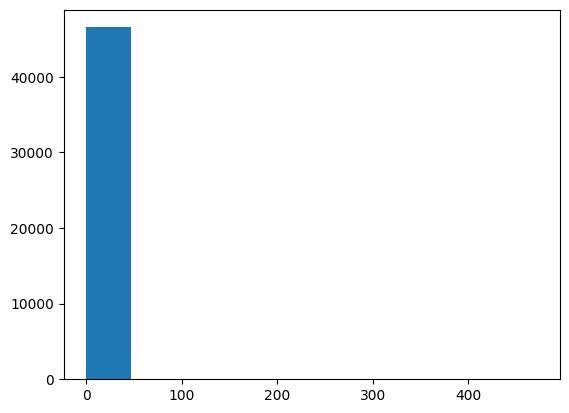

In [7]:
plt.hist(x['txId2'])

(array([8.8960e+03, 2.4558e+04, 1.0140e+03, 3.0900e+02, 1.1500e+02,
        2.2000e+01, 4.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.        , 0.61590954, 1.23181908, 1.84772862, 2.46363816,
        3.07954769, 3.69545723, 4.31136677, 4.92727631, 5.54318585,
        6.15909539]),
 <BarContainer object of 10 artists>)

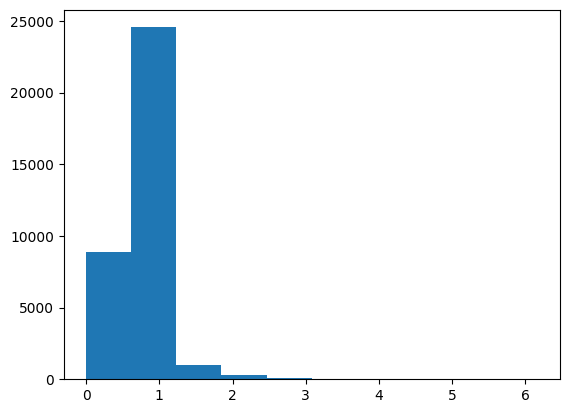

In [8]:
plt.hist(x_train['txId2'])

In [9]:
y = classes[classes['class'] == 'unknown']
x = features[features.iloc[:, 0].isin(y['txId'])]
x = x.iloc[:, 2:]
x.fillna(0, inplace=True)
x['txId2']=x['txId2'].apply(lambda x: np.log(1+x))

Uczenie modeli
----------------------

Metryka accuracy

In [10]:
def createModel(metrics):
    model = Sequential()
    model.add(GRU(64, input_shape=(x_train.shape[1],1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse', metrics=metrics)
    history=model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
    loss, accuracy = model.evaluate(x_test, y_test)
    return model, history

In [11]:
def evalModel(model):
    res=np.round(model.predict(x))
    unique, counts = np.unique(res, return_counts=True)
    dict(zip(unique, counts))
    classes_illicit = classes[classes['class'] == '1']
    classes_licit = classes[classes['class'] == '2']
    res = np.round(model.predict(x_test))
    confusion_matrix = metrics.confusion_matrix(y_test, res)
    return res, confusion_matrix, classes_illicit['txId'].count()/classes_licit['txId'].count(), counts[1]/counts[0]

In [12]:
def displayConfunsion(axs,x,y,confusion_matrix):
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot(ax=axs[x,y], cmap=plt.cm.Blues, xticks_rotation='vertical')
    
def displayResult(exampleCount, predictedCount):
    print("Marked example proportion: "+str(exampleCount)+" - Predicted proportion: "+str(predictedCount))

In [13]:
def createTeamOfModels(metrics):
    meanPredicted=[]
    for i in range(6):
        model, history=createModel(metrics)
        res, matrix, examplesCount, predictedCount = evalModel(model)
        meanPredicted.append((res, matrix, examplesCount, predictedCount, history))
    return meanPredicted

In [14]:
def displaySummarization(meanPredicted):
    fig, axs = plt.subplots(3, 2)
    fig2, axs2 = plt.subplots(3, 2)
    fig3, axs3 = plt.subplots(3, 2)
    meanTotal=[0,0]
    for i in range(3):
        for v in range(2):
            displayConfunsion(axs,i,v,meanPredicted[i+v*3][1])
            displayResult(meanPredicted[i+v*3][2],meanPredicted[i+v*3][3])            
            fpr, tpr, thresholds = roc_curve(y_test, meanPredicted[i+v*3][0])
            auc1 = roc_auc_score(y_test, meanPredicted[i+v*3][0])
            axs2[i,v].plot(fpr, tpr, label='Model 1 (AUC = {:.2f})'.format(auc1))
            axs3[i,v].plot(meanPredicted[i+v*3][4].history['loss'], label='Training MSE')
            axs3[i,v].plot(meanPredicted[i+v*3][4].history['val_loss'], label='Validation MSE')
            meanTotal[0]=meanTotal[0]+meanPredicted[i+v*3][2]
            meanTotal[1]=meanTotal[1]+meanPredicted[i+v*3][3]

    plt.show()
    print("Final proportion: ")
    displayResult(meanTotal[0]/6, meanTotal[1]/6)

Epoch 1/5


2023-05-14 17:11:41.923608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:11:41.924837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:11:41.926140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9184

2023-05-14 17:12:14.449141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:12:14.450889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:12:14.452366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 35s 31ms/step - loss: 0.0712 - accuracy: 0.9184 - val_loss: 0.0488 - val_accuracy: 0.9442
Epoch 2/5
1092/1092 [==============================] - 33s 30ms/step - loss: 0.0415 - accuracy: 0.9531 - val_loss: 0.0384 - val_accuracy: 0.9561
Epoch 3/5
1092/1092 [==============================] - 33s 31ms/step - loss: 0.0401 - accuracy: 0.9534 - val_loss: 0.0382 - val_accuracy: 0.9560
Epoch 4/5
1092/1092 [==============================] - 33s 31ms/step - loss: 0.0354 - accuracy: 0.9584 - val_loss: 0.0330 - val_accuracy: 0.9627
Epoch 5/5
   8/4913 [..............................] - ETA: 37s  

2023-05-14 17:14:33.428877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:14:33.430216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:14:33.431489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 7ms/step
Epoch 1/5


2023-05-14 17:15:15.227674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:15:15.228516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:15:15.229907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9217

2023-05-14 17:15:47.293728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:15:47.295012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:15:47.298336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 35s 30ms/step - loss: 0.0688 - accuracy: 0.9217 - val_loss: 0.0498 - val_accuracy: 0.9414
Epoch 2/5
1092/1092 [==============================] - 33s 30ms/step - loss: 0.0479 - accuracy: 0.9433 - val_loss: 0.0651 - val_accuracy: 0.9220
Epoch 3/5
1092/1092 [==============================] - 33s 30ms/step - loss: 0.0492 - accuracy: 0.9414 - val_loss: 0.0482 - val_accuracy: 0.9389
Epoch 4/5
1092/1092 [==============================] - 32s 29ms/step - loss: 0.0584 - accuracy: 0.9303 - val_loss: 0.0503 - val_accuracy: 0.9427
Epoch 5/5
   9/4913 [..............................] - ETA: 34s  

2023-05-14 17:18:01.327703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:18:01.328844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:18:01.329970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 7ms/step
Epoch 1/5


2023-05-14 17:18:39.928265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:18:39.929153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:18:39.930152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0716 - accuracy: 0.9189

2023-05-14 17:19:10.082530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:19:10.083854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:19:10.085270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 33s 29ms/step - loss: 0.0716 - accuracy: 0.9189 - val_loss: 0.0466 - val_accuracy: 0.9473
Epoch 2/5
1092/1092 [==============================] - 31s 28ms/step - loss: 0.0458 - accuracy: 0.9461 - val_loss: 0.0440 - val_accuracy: 0.9493
Epoch 3/5
1092/1092 [==============================] - 31s 28ms/step - loss: 0.0437 - accuracy: 0.9483 - val_loss: 0.0500 - val_accuracy: 0.9418
Epoch 4/5
1092/1092 [==============================] - 31s 28ms/step - loss: 0.0428 - accuracy: 0.9485 - val_loss: 0.0413 - val_accuracy: 0.9510
Epoch 5/5
   9/4913 [..............................] - ETA: 34s  

2023-05-14 17:21:19.596851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:21:19.598116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:21:19.599330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 7ms/step
Epoch 1/5


2023-05-14 17:21:58.251738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:21:58.252760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:21:58.253671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9196

2023-05-14 17:22:48.956901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:22:48.958383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:22:48.959846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 54s 48ms/step - loss: 0.0680 - accuracy: 0.9196 - val_loss: 0.0515 - val_accuracy: 0.9418
Epoch 2/5
1092/1092 [==============================] - 38s 35ms/step - loss: 0.0484 - accuracy: 0.9401 - val_loss: 0.0438 - val_accuracy: 0.9482
Epoch 3/5
1092/1092 [==============================] - 37s 34ms/step - loss: 0.0425 - accuracy: 0.9482 - val_loss: 0.0552 - val_accuracy: 0.9278
Epoch 4/5
1092/1092 [==============================] - 38s 34ms/step - loss: 0.0369 - accuracy: 0.9564 - val_loss: 0.0357 - val_accuracy: 0.9594
Epoch 5/5
   8/4913 [..............................] - ETA: 38s  

2023-05-14 17:25:24.037383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:25:24.038771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:25:24.040169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-14 17:26:08.462333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:26:08.463327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:26:08.464592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0708 - accuracy: 0.9189

2023-05-14 17:26:42.565085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:26:42.566694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:26:42.568294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 37s 32ms/step - loss: 0.0708 - accuracy: 0.9189 - val_loss: 0.0510 - val_accuracy: 0.9422
Epoch 2/5
1092/1092 [==============================] - 35s 32ms/step - loss: 0.0479 - accuracy: 0.9445 - val_loss: 0.0469 - val_accuracy: 0.9476
Epoch 3/5
1092/1092 [==============================] - 35s 32ms/step - loss: 0.0504 - accuracy: 0.9387 - val_loss: 0.0754 - val_accuracy: 0.9072
Epoch 4/5
1092/1092 [==============================] - 35s 32ms/step - loss: 0.0710 - accuracy: 0.9115 - val_loss: 0.0700 - val_accuracy: 0.9075
Epoch 5/5
   9/4913 [..............................] - ETA: 34s  

2023-05-14 17:29:07.167733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:29:07.169101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:29:07.170408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 7ms/step
Epoch 1/5


2023-05-14 17:29:47.661384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:29:47.662276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:29:47.663242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0714 - accuracy: 0.9169

2023-05-14 17:30:19.475897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:30:19.477667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:30:19.479603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 34s 30ms/step - loss: 0.0714 - accuracy: 0.9169 - val_loss: 0.0497 - val_accuracy: 0.9447
Epoch 2/5
1092/1092 [==============================] - 33s 30ms/step - loss: 0.0491 - accuracy: 0.9409 - val_loss: 0.0551 - val_accuracy: 0.9313
Epoch 3/5
1092/1092 [==============================] - 32s 30ms/step - loss: 0.0469 - accuracy: 0.9438 - val_loss: 0.0475 - val_accuracy: 0.9480
Epoch 4/5
1092/1092 [==============================] - 33s 30ms/step - loss: 0.0426 - accuracy: 0.9508 - val_loss: 0.0451 - val_accuracy: 0.9488
Epoch 5/5
   9/4913 [..............................] - ETA: 34s  

2023-05-14 17:32:36.216185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:32:36.217841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:32:36.219359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 7ms/step
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.07698262632905842
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.056116142208368046
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0613210731694144
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.04799141367678626
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0384930439033413
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0365688815039002


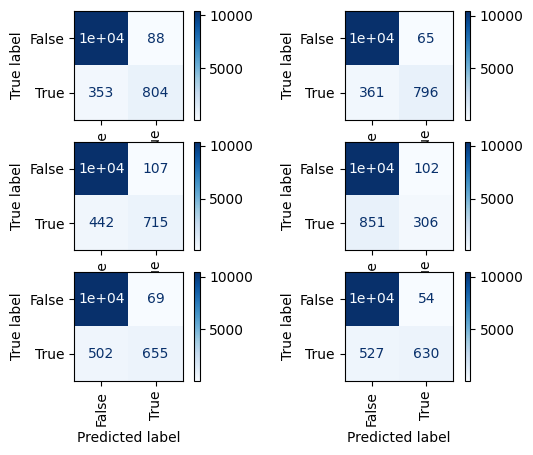

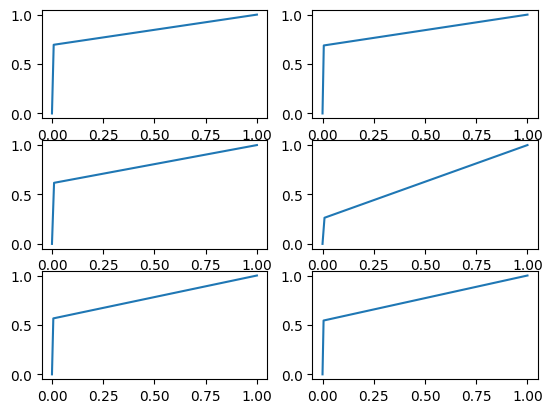

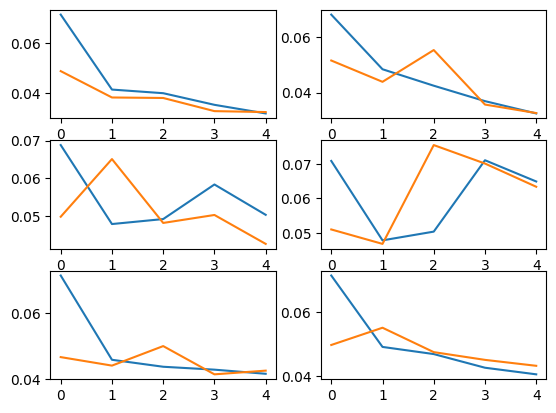

Final proportion: 
Marked example proportion: 0.1081653537685333 - Predicted proportion: 0.052912196798478105


In [14]:
meanPredicted=createTeamOfModels(['accuracy'])
displaySummarization(meanPredicted)

Metryka MSE

Epoch 1/5


2023-05-14 17:33:17.763064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:33:17.764014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:33:17.765105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - ETA: 0s - loss: 0.0728 - mse: 0.0728

2023-05-14 17:33:49.299094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:33:49.300370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:33:49.302122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 476s 434ms/step - loss: 0.0728 - mse: 0.0728 - val_loss: 0.0559 - val_mse: 0.0559
Epoch 2/5
1092/1092 [==============================] - 1417s 1s/step - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0638 - val_mse: 0.0638
Epoch 3/5
1092/1092 [==============================] - 2186s 2s/step - loss: 0.0507 - mse: 0.0507 - val_loss: 0.0521 - val_mse: 0.0521
Epoch 4/5
1092/1092 [==============================] - 39s 36ms/step - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0408 - val_mse: 0.0408
Epoch 5/5
   8/4913 [..............................] - ETA: 38s  

2023-05-14 18:42:32.700027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 18:42:32.701212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 18:42:32.702552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-14 18:43:14.726669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 18:43:14.727517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 18:43:14.728849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - ETA: 0s - loss: 0.0750 - mse: 0.0750

2023-05-14 18:43:47.714364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 18:43:47.715839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 18:43:47.717347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 36s 31ms/step - loss: 0.0750 - mse: 0.0750 - val_loss: 0.0536 - val_mse: 0.0536
Epoch 2/5
1092/1092 [==============================] - 34s 31ms/step - loss: 0.0472 - mse: 0.0472 - val_loss: 0.0468 - val_mse: 0.0468
Epoch 3/5
1092/1092 [==============================] - 34s 31ms/step - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0449 - val_mse: 0.0449
Epoch 4/5
1092/1092 [==============================] - 34s 31ms/step - loss: 0.0443 - mse: 0.0443 - val_loss: 0.0444 - val_mse: 0.0444
Epoch 5/5
   8/4913 [..............................] - ETA: 38s  

2023-05-14 18:46:09.126750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 18:46:09.127995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 18:46:09.129279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 7ms/step
Epoch 1/5


2023-05-14 18:46:50.670765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 18:46:50.671824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 18:46:50.672963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - ETA: 0s - loss: 0.0693 - mse: 0.0693

2023-05-14 18:47:21.981760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 18:47:21.983070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 18:47:21.985208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 34s 30ms/step - loss: 0.0693 - mse: 0.0693 - val_loss: 0.0472 - val_mse: 0.0472
Epoch 2/5
1092/1092 [==============================] - 32s 30ms/step - loss: 0.0422 - mse: 0.0422 - val_loss: 0.0408 - val_mse: 0.0408
Epoch 3/5
1092/1092 [==============================] - 32s 29ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/5
1092/1092 [==============================] - 32s 29ms/step - loss: 0.0329 - mse: 0.0329 - val_loss: 0.0386 - val_mse: 0.0386
Epoch 5/5
   9/4913 [..............................] - ETA: 34s  

2023-05-14 18:49:36.308132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 18:49:36.309187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 18:49:36.311169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 9ms/step
Epoch 1/5


2023-05-14 19:02:50.903999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:02:50.905673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:02:50.907059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - ETA: 0s - loss: 0.0713 - mse: 0.0713

2023-05-14 19:03:33.933428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:03:33.936357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:03:33.938316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 46s 40ms/step - loss: 0.0713 - mse: 0.0713 - val_loss: 0.0499 - val_mse: 0.0499
Epoch 2/5
1092/1092 [==============================] - 39s 36ms/step - loss: 0.0486 - mse: 0.0486 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 3/5
1092/1092 [==============================] - 36s 33ms/step - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0473 - val_mse: 0.0473
Epoch 4/5
1092/1092 [==============================] - 37s 34ms/step - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 5/5
   7/4913 [..............................] - ETA: 41s  

2023-05-14 19:06:11.048363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:06:11.049994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:06:11.051718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step


2023-05-14 19:06:55.443167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:06:55.447796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:06:55.449450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-05-14 19:06:55.911970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:06:55.913864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:06:55.915351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - ETA: 0s - loss: 0.0712 - mse: 0.0712

2023-05-14 19:07:33.415136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:07:33.416631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:07:33.418151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 41s 35ms/step - loss: 0.0712 - mse: 0.0712 - val_loss: 0.0580 - val_mse: 0.0580
Epoch 2/5
1092/1092 [==============================] - 36s 33ms/step - loss: 0.0456 - mse: 0.0456 - val_loss: 0.0450 - val_mse: 0.0450
Epoch 3/5
1092/1092 [==============================] - 35s 32ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0453 - val_mse: 0.0453
Epoch 4/5
1092/1092 [==============================] - 36s 33ms/step - loss: 0.0399 - mse: 0.0399 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 5/5
   8/4913 [..............................] - ETA: 39s  

2023-05-14 19:10:02.393614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:10:02.394858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:10:02.396046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-14 19:10:46.608516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:10:46.609487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:10:46.610687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0715 - mse: 0.0715

2023-05-14 19:11:21.775911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:11:21.778435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:11:21.780342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 38s 33ms/step - loss: 0.0715 - mse: 0.0715 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 2/5
1092/1092 [==============================] - 34s 31ms/step - loss: 0.0431 - mse: 0.0431 - val_loss: 0.0412 - val_mse: 0.0412
Epoch 3/5
1092/1092 [==============================] - 34s 31ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 4/5
1092/1092 [==============================] - 33s 31ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 5/5
   8/4913 [..............................] - ETA: 36s  

2023-05-14 19:13:42.613326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:13:42.614428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:13:42.615753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.05622257906300181
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.04511398161136559
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.07230312745131476
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.044836134760964784
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.048942416761193035
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.056634336835171634


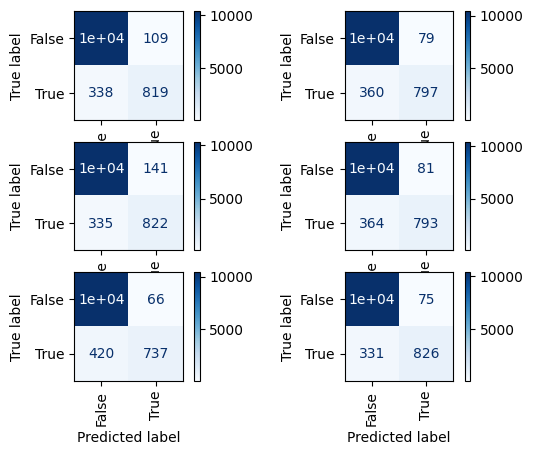

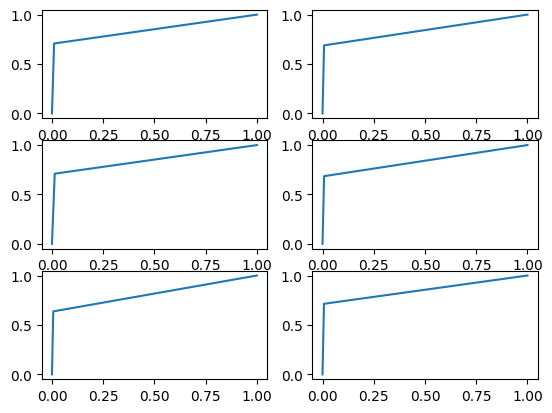

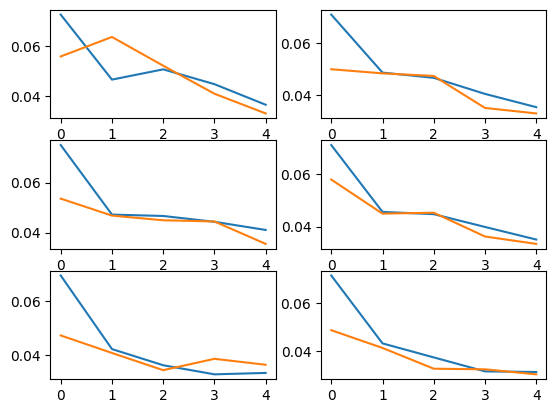

Final proportion: 
Marked example proportion: 0.1081653537685333 - Predicted proportion: 0.05400876274716859


In [15]:
meanPredicted=createTeamOfModels(['mse'])
displaySummarization(meanPredicted)

Metryka AUC

Epoch 1/5


2023-05-14 19:26:59.235202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:26:59.236090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:26:59.237363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - ETA: 0s - loss: 0.0705 - sensitivity_at_specificity: 0.8545

2023-05-14 19:27:35.426954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:27:35.428593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:27:35.430079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 39s 34ms/step - loss: 0.0705 - sensitivity_at_specificity: 0.8545 - val_loss: 0.0484 - val_sensitivity_at_specificity: 0.8816
Epoch 2/5
1092/1092 [==============================] - 36s 33ms/step - loss: 0.0445 - sensitivity_at_specificity: 0.8757 - val_loss: 0.0432 - val_sensitivity_at_specificity: 0.8591
Epoch 3/5
1092/1092 [==============================] - 36s 33ms/step - loss: 0.0385 - sensitivity_at_specificity: 0.9011 - val_loss: 0.0371 - val_sensitivity_at_specificity: 0.8997
Epoch 4/5
1092/1092 [==============================] - 36s 33ms/step - loss: 0.0344 - sensitivity_at_specificity: 0.9295 - val_loss: 0.0329 - val_sensitivity_at_specificity: 0.9041
Epoch 5/5
   8/4913 [..............................] - ETA: 38s  

2023-05-14 19:30:05.539988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:30:05.541203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:30:05.542609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-14 19:30:48.727021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:30:48.728292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:30:48.729238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0705 - sensitivity_at_specificity: 0.8649

2023-05-14 19:31:23.202516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:31:23.203930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:31:23.205519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 37s 33ms/step - loss: 0.0704 - sensitivity_at_specificity: 0.8649 - val_loss: 0.0481 - val_sensitivity_at_specificity: 0.8850
Epoch 2/5
1092/1092 [==============================] - 37s 34ms/step - loss: 0.0431 - sensitivity_at_specificity: 0.8754 - val_loss: 0.0390 - val_sensitivity_at_specificity: 0.8669
Epoch 3/5
1092/1092 [==============================] - 37s 33ms/step - loss: 0.0358 - sensitivity_at_specificity: 0.8778 - val_loss: 0.0334 - val_sensitivity_at_specificity: 0.8989
Epoch 4/5
1092/1092 [==============================] - 36s 33ms/step - loss: 0.0359 - sensitivity_at_specificity: 0.8884 - val_loss: 0.0446 - val_sensitivity_at_specificity: 0.8600
Epoch 5/5
   7/4913 [..............................] - ETA: 48s  

2023-05-14 19:33:55.102021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:33:55.103254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:33:55.104656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-14 19:34:42.656223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:34:42.657753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:34:42.658944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0693 - sensitivity_at_specificity: 0.8862

2023-05-14 19:35:20.849086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:35:20.850548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:35:20.852106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 41s 36ms/step - loss: 0.0693 - sensitivity_at_specificity: 0.8862 - val_loss: 0.0646 - val_sensitivity_at_specificity: 0.8583
Epoch 2/5
1092/1092 [==============================] - 37s 33ms/step - loss: 0.0496 - sensitivity_at_specificity: 0.9020 - val_loss: 0.0472 - val_sensitivity_at_specificity: 0.8617
Epoch 3/5
1092/1092 [==============================] - 38s 35ms/step - loss: 0.0435 - sensitivity_at_specificity: 0.8870 - val_loss: 0.0478 - val_sensitivity_at_specificity: 0.8997
Epoch 4/5
1092/1092 [==============================] - 45s 41ms/step - loss: 0.0416 - sensitivity_at_specificity: 0.9206 - val_loss: 0.0469 - val_sensitivity_at_specificity: 0.9127
Epoch 5/5
   8/4913 [..............................] - ETA: 39s  

2023-05-14 19:38:05.559609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:38:05.560662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:38:05.562008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-14 19:38:46.933321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:38:46.934355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:38:46.935535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0735 - sensitivity_at_specificity: 0.8259

2023-05-14 19:39:22.404113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:39:22.405712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:39:22.407289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 38s 33ms/step - loss: 0.0735 - sensitivity_at_specificity: 0.8260 - val_loss: 0.0513 - val_sensitivity_at_specificity: 0.8444
Epoch 2/5
1092/1092 [==============================] - 37s 34ms/step - loss: 0.0510 - sensitivity_at_specificity: 0.8890 - val_loss: 0.0458 - val_sensitivity_at_specificity: 0.8816
Epoch 3/5
1092/1092 [==============================] - 37s 34ms/step - loss: 0.0411 - sensitivity_at_specificity: 0.8778 - val_loss: 0.0408 - val_sensitivity_at_specificity: 0.8885
Epoch 4/5
1092/1092 [==============================] - 37s 34ms/step - loss: 0.0362 - sensitivity_at_specificity: 0.8905 - val_loss: 0.0357 - val_sensitivity_at_specificity: 0.8686
Epoch 5/5
   8/4913 [..............................] - ETA: 38s  

2023-05-14 19:41:56.244022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:41:56.245135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:41:56.246631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-14 19:42:39.422383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:42:39.423394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:42:39.424505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - ETA: 0s - loss: 0.0718 - sensitivity_at_specificity: 0.8807

2023-05-14 19:43:15.003026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:43:15.004612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:43:15.006028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 39s 34ms/step - loss: 0.0718 - sensitivity_at_specificity: 0.8807 - val_loss: 0.0621 - val_sensitivity_at_specificity: 0.9378
Epoch 2/5
1092/1092 [==============================] - 37s 34ms/step - loss: 0.0507 - sensitivity_at_specificity: 0.9005 - val_loss: 0.0452 - val_sensitivity_at_specificity: 0.8928
Epoch 3/5
1092/1092 [==============================] - 37s 34ms/step - loss: 0.0441 - sensitivity_at_specificity: 0.9106 - val_loss: 0.0433 - val_sensitivity_at_specificity: 0.9309
Epoch 4/5
1092/1092 [==============================] - 37s 34ms/step - loss: 0.0381 - sensitivity_at_specificity: 0.9215 - val_loss: 0.0424 - val_sensitivity_at_specificity: 0.9067
Epoch 5/5
   8/4913 [..............................] - ETA: 40s  

2023-05-14 19:45:51.321687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:45:51.322792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:45:51.324323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 4s 10ms/step
Epoch 1/5


2023-05-14 19:46:39.103082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:46:39.104341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:46:39.105698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0723 - sensitivity_at_specificity: 0.8776

2023-05-14 19:47:26.109221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:47:26.111473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:47:26.113307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 50s 44ms/step - loss: 0.0723 - sensitivity_at_specificity: 0.8777 - val_loss: 0.0532 - val_sensitivity_at_specificity: 0.8902
Epoch 2/5
1092/1092 [==============================] - 54s 49ms/step - loss: 0.0475 - sensitivity_at_specificity: 0.9029 - val_loss: 0.0473 - val_sensitivity_at_specificity: 0.9196
Epoch 3/5
1092/1092 [==============================] - 48s 44ms/step - loss: 0.0469 - sensitivity_at_specificity: 0.9321 - val_loss: 0.0433 - val_sensitivity_at_specificity: 0.9144
Epoch 4/5
1092/1092 [==============================] - 54s 50ms/step - loss: 0.0432 - sensitivity_at_specificity: 0.9300 - val_loss: 0.0416 - val_sensitivity_at_specificity: 0.9067
Epoch 5/5
   8/4913 [..............................] - ETA: 37s  

2023-05-14 19:51:01.617051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 19:51:01.618178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 19:51:01.619770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.05768648532271195
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.06799051611106205
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.04972689272025534
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.07180599019587791
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0429437677467293
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.04652633541034244


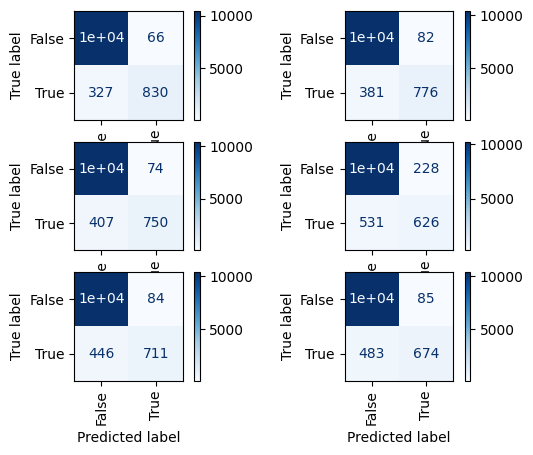

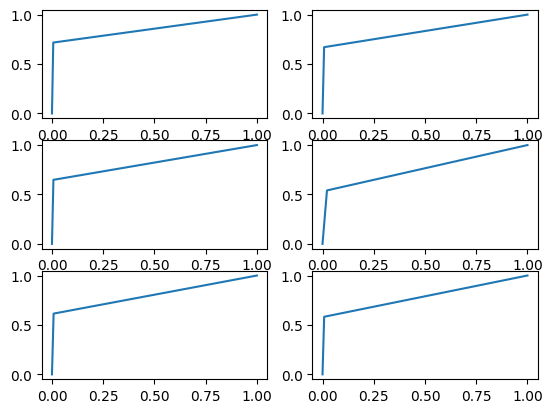

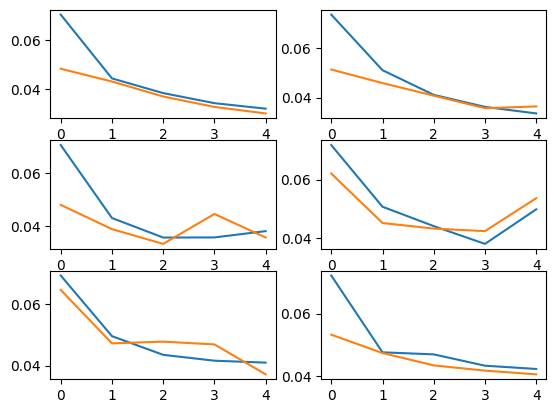

Final proportion: 
Marked example proportion: 0.1081653537685333 - Predicted proportion: 0.05611333125116317


In [20]:
meanPredicted=createTeamOfModels(tf.metrics.SensitivityAtSpecificity(0.5))
displaySummarization(meanPredicted)

Specyficzna czułość

Epoch 1/5


2023-05-14 20:01:46.561215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:01:46.562248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:01:46.563390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - ETA: 0s - loss: 0.0696 - auc: 0.6351

2023-05-14 20:02:33.590984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:02:33.592419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:02:33.594008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 50s 44ms/step - loss: 0.0696 - auc: 0.6351 - val_loss: 0.0497 - val_auc: 0.7886
Epoch 2/5
1092/1092 [==============================] - 49s 45ms/step - loss: 0.0459 - auc: 0.7871 - val_loss: 0.0435 - val_auc: 0.7952
Epoch 3/5
1092/1092 [==============================] - 46s 42ms/step - loss: 0.0403 - auc: 0.8189 - val_loss: 0.0362 - val_auc: 0.8303
Epoch 4/5
1092/1092 [==============================] - 48s 44ms/step - loss: 0.0348 - auc: 0.8413 - val_loss: 0.0324 - val_auc: 0.8394
Epoch 5/5
   8/4913 [..............................] - ETA: 40s  

2023-05-14 20:05:51.957833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:05:51.959086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:05:51.960397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 9ms/step
Epoch 1/5


2023-05-14 20:06:38.183157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:06:38.184365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:06:38.185625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0720 - auc: 0.6691

2023-05-14 20:07:24.652443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:07:24.654446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:07:24.655980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 50s 44ms/step - loss: 0.0720 - auc: 0.6691 - val_loss: 0.0486 - val_auc: 0.7642
Epoch 2/5
1092/1092 [==============================] - 47s 43ms/step - loss: 0.0452 - auc: 0.7890 - val_loss: 0.0447 - val_auc: 0.7947
Epoch 3/5
1092/1092 [==============================] - 46s 42ms/step - loss: 0.0398 - auc: 0.8134 - val_loss: 0.0366 - val_auc: 0.8159
Epoch 4/5
1092/1092 [==============================] - 43s 39ms/step - loss: 0.0354 - auc: 0.8326 - val_loss: 0.0321 - val_auc: 0.8450
Epoch 5/5
   8/4913 [..............................] - ETA: 35s  

2023-05-14 20:10:29.958926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:10:29.960633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:10:29.961756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-14 20:11:13.130522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:11:13.131796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:11:13.132615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0727 - auc: 0.6745

2023-05-14 20:11:46.567437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:11:46.568955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:11:46.572060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 36s 32ms/step - loss: 0.0727 - auc: 0.6746 - val_loss: 0.0548 - val_auc: 0.7210
Epoch 2/5
1092/1092 [==============================] - 34s 31ms/step - loss: 0.0476 - auc: 0.7699 - val_loss: 0.0461 - val_auc: 0.8024
Epoch 3/5
1092/1092 [==============================] - 34s 31ms/step - loss: 0.0391 - auc: 0.8176 - val_loss: 0.0352 - val_auc: 0.8303
Epoch 4/5
1092/1092 [==============================] - 34s 31ms/step - loss: 0.0329 - auc: 0.8491 - val_loss: 0.0315 - val_auc: 0.8543
Epoch 5/5
   8/4913 [..............................] - ETA: 37s  

2023-05-14 20:14:10.312339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:14:10.313401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:14:10.314595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-14 20:14:53.015563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:14:53.016506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:14:53.017560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0721 - auc: 0.6758

2023-05-14 20:15:36.980349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:15:36.982079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:15:36.983473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 47s 41ms/step - loss: 0.0721 - auc: 0.6758 - val_loss: 0.0473 - val_auc: 0.7969
Epoch 2/5
1092/1092 [==============================] - 40s 36ms/step - loss: 0.0461 - auc: 0.7961 - val_loss: 0.0439 - val_auc: 0.7985
Epoch 3/5
1092/1092 [==============================] - 46s 42ms/step - loss: 0.0427 - auc: 0.8024 - val_loss: 0.0403 - val_auc: 0.7964
Epoch 4/5
1092/1092 [==============================] - 44s 40ms/step - loss: 0.0390 - auc: 0.8142 - val_loss: 0.0374 - val_auc: 0.8068
Epoch 5/5
   6/4913 [..............................] - ETA: 53s  

2023-05-14 20:18:34.752677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:18:34.755061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:18:34.756792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-14 20:19:18.161174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:19:18.162204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:19:18.163215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - ETA: 0s - loss: 0.0679 - auc: 0.6933

2023-05-14 20:19:53.541084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:19:53.542718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:19:53.544356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 38s 33ms/step - loss: 0.0679 - auc: 0.6933 - val_loss: 0.0500 - val_auc: 0.8061
Epoch 2/5
1092/1092 [==============================] - 44s 41ms/step - loss: 0.0480 - auc: 0.7882 - val_loss: 0.0490 - val_auc: 0.7468
Epoch 3/5
1092/1092 [==============================] - 42s 39ms/step - loss: 0.0500 - auc: 0.7419 - val_loss: 0.0465 - val_auc: 0.7804
Epoch 4/5
1092/1092 [==============================] - 42s 38ms/step - loss: 0.0427 - auc: 0.7960 - val_loss: 0.0426 - val_auc: 0.7825
Epoch 5/5
   8/4913 [..............................] - ETA: 39s  

2023-05-14 20:22:50.834536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:22:50.835836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:22:50.837008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-14 20:23:33.107637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:23:33.108542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:23:33.109671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0763 - auc: 0.6523

2023-05-14 20:24:16.807247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:24:16.808554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:24:16.810215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 47s 41ms/step - loss: 0.0762 - auc: 0.6523 - val_loss: 0.0507 - val_auc: 0.7868
Epoch 2/5
1092/1092 [==============================] - 44s 41ms/step - loss: 0.0477 - auc: 0.7761 - val_loss: 0.0443 - val_auc: 0.8148
Epoch 3/5
1092/1092 [==============================] - 43s 39ms/step - loss: 0.0426 - auc: 0.8095 - val_loss: 0.0358 - val_auc: 0.8411
Epoch 4/5
1092/1092 [==============================] - 44s 41ms/step - loss: 0.0345 - auc: 0.8436 - val_loss: 0.0339 - val_auc: 0.8428
Epoch 5/5
   7/4913 [..............................] - ETA: 42s  

2023-05-14 20:27:19.765781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 20:27:19.766946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 20:27:19.768614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.06294287877968302
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.05685454594347487
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.06934174993707953
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0684841193782327
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.05360338321928596
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.07429629680249841


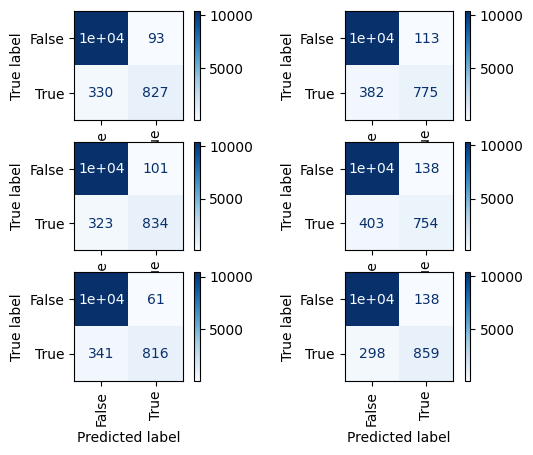

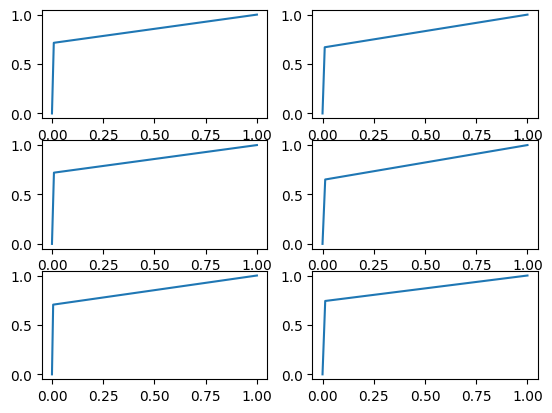

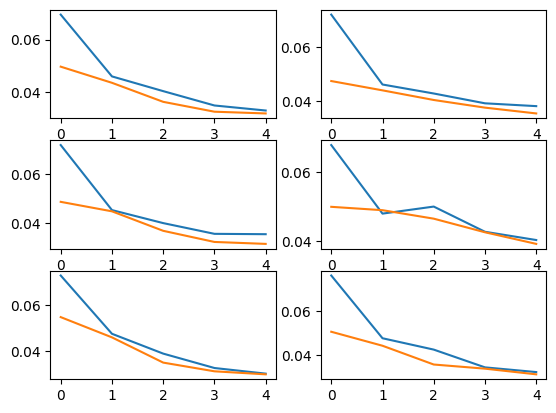

Final proportion: 
Marked example proportion: 0.1081653537685333 - Predicted proportion: 0.06425382901004241


In [23]:
meanPredicted=createTeamOfModels(tf.keras.metrics.AUC(num_thresholds=3))
displaySummarization(meanPredicted)

Epoch 1/5


2023-05-14 21:16:39.059018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:16:39.059932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:16:39.061166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0772 - recall: 0.1538

2023-05-14 21:17:14.127036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:17:14.128467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:17:14.129887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 38s 33ms/step - loss: 0.0772 - recall: 0.1538 - val_loss: 0.0868 - val_recall: 0.0000e+00
Epoch 2/5
1092/1092 [==============================] - 38s 35ms/step - loss: 0.0663 - recall: 0.2594 - val_loss: 0.0518 - val_recall: 0.5367
Epoch 3/5
1092/1092 [==============================] - 38s 35ms/step - loss: 0.0464 - recall: 0.5877 - val_loss: 0.0467 - val_recall: 0.5497
Epoch 4/5
1092/1092 [==============================] - 37s 34ms/step - loss: 0.0437 - recall: 0.5945 - val_loss: 0.0443 - val_recall: 0.6309
Epoch 5/5
   8/4913 [..............................] - ETA: 39s  

2023-05-14 21:19:49.543204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:19:49.544657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:19:49.545729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-14 21:20:34.857818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:20:34.859287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:20:34.860313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - ETA: 0s - loss: 0.0731 - recall: 0.3250

2023-05-14 21:21:10.550748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:21:10.552075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:21:10.553930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 39s 34ms/step - loss: 0.0731 - recall: 0.3250 - val_loss: 0.0531 - val_recall: 0.4901
Epoch 2/5
1092/1092 [==============================] - 39s 36ms/step - loss: 0.0495 - recall: 0.5148 - val_loss: 0.0589 - val_recall: 0.2982
Epoch 3/5
1092/1092 [==============================] - 39s 36ms/step - loss: 0.0487 - recall: 0.5372 - val_loss: 0.0448 - val_recall: 0.6076
Epoch 4/5
1092/1092 [==============================] - 38s 35ms/step - loss: 0.0422 - recall: 0.5956 - val_loss: 0.0421 - val_recall: 0.5575
Epoch 5/5
   8/4913 [..............................] - ETA: 40s  

2023-05-14 21:23:52.327644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:23:52.328833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:23:52.330200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-14 21:24:35.724243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:24:35.725228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:24:35.726319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0714 - recall: 0.3335

2023-05-14 21:25:12.941916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:25:12.943716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:25:12.945598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 41s 36ms/step - loss: 0.0715 - recall: 0.3333 - val_loss: 0.0561 - val_recall: 0.2697
Epoch 2/5
1092/1092 [==============================] - 38s 35ms/step - loss: 0.0647 - recall: 0.4115 - val_loss: 0.0816 - val_recall: 0.0000e+00
Epoch 3/5
1092/1092 [==============================] - 38s 35ms/step - loss: 0.0673 - recall: 0.2119 - val_loss: 0.0558 - val_recall: 0.4849
Epoch 4/5
1092/1092 [==============================] - 39s 36ms/step - loss: 0.0486 - recall: 0.5463 - val_loss: 0.0470 - val_recall: 0.5082
Epoch 5/5
   8/4913 [..............................] - ETA: 40s  

2023-05-14 21:27:54.463946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:27:54.465292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:27:54.466685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-14 21:28:46.958248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:28:46.959329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:28:46.960699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0739 - recall: 0.3112

2023-05-14 21:29:25.570928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:29:25.572499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:29:25.573859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 41s 36ms/step - loss: 0.0739 - recall: 0.3113 - val_loss: 0.0503 - val_recall: 0.5912
Epoch 2/5
1092/1092 [==============================] - 48s 44ms/step - loss: 0.0470 - recall: 0.5823 - val_loss: 0.0432 - val_recall: 0.6387
Epoch 3/5
1092/1092 [==============================] - 46s 42ms/step - loss: 0.0412 - recall: 0.6390 - val_loss: 0.0425 - val_recall: 0.6093
Epoch 4/5
1092/1092 [==============================] - 44s 40ms/step - loss: 0.0387 - recall: 0.6523 - val_loss: 0.0326 - val_recall: 0.6992
Epoch 5/5
   7/4913 [..............................] - ETA: 46s  

2023-05-14 21:32:35.675073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:32:35.676731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:32:35.677944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 4s 10ms/step
Epoch 1/5


2023-05-14 21:33:28.128274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:33:28.129787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:33:28.130870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - ETA: 0s - loss: 0.0684 - recall: 0.3886

2023-05-14 21:34:22.100877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:34:22.102423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:34:22.103875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 57s 51ms/step - loss: 0.0684 - recall: 0.3886 - val_loss: 0.0485 - val_recall: 0.5592
Epoch 2/5
1092/1092 [==============================] - 57s 52ms/step - loss: 0.0460 - recall: 0.5788 - val_loss: 0.0425 - val_recall: 0.6275
Epoch 3/5
1092/1092 [==============================] - 58s 53ms/step - loss: 0.1579 - recall: 0.6588 - val_loss: 0.6432 - val_recall: 0.9784
Epoch 4/5
1092/1092 [==============================] - 56s 52ms/step - loss: 0.1212 - recall: 0.4894 - val_loss: 0.0482 - val_recall: 0.6266
Epoch 5/5
   1/4913 [..............................] - ETA: 31:54

2023-05-14 21:38:15.257719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:38:15.259607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:38:15.261598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 4s 11ms/step
Epoch 1/5


2023-05-14 21:39:08.463446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:39:08.464545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:39:08.466027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0731 - recall: 0.3311

2023-05-14 21:39:51.291519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:39:51.294132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:39:51.295949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 47s 41ms/step - loss: 0.0731 - recall: 0.3311 - val_loss: 0.0471 - val_recall: 0.6085
Epoch 2/5
1092/1092 [==============================] - 43s 39ms/step - loss: 0.0449 - recall: 0.6051 - val_loss: 0.0433 - val_recall: 0.6076
Epoch 3/5
1092/1092 [==============================] - 37s 34ms/step - loss: 0.0432 - recall: 0.6210 - val_loss: 0.0422 - val_recall: 0.5981
Epoch 4/5
1092/1092 [==============================] - 40s 37ms/step - loss: 0.0413 - recall: 0.6287 - val_loss: 0.0399 - val_recall: 0.6448
Epoch 5/5
   7/4913 [..............................] - ETA: 43s  

2023-05-14 21:42:39.038575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 21:42:39.040248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 21:42:39.041590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 9ms/step
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.03810901118639143
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.04979699228036435
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.05262276860444873
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.05764378990426341
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.04443351913737319
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.06145006211851132


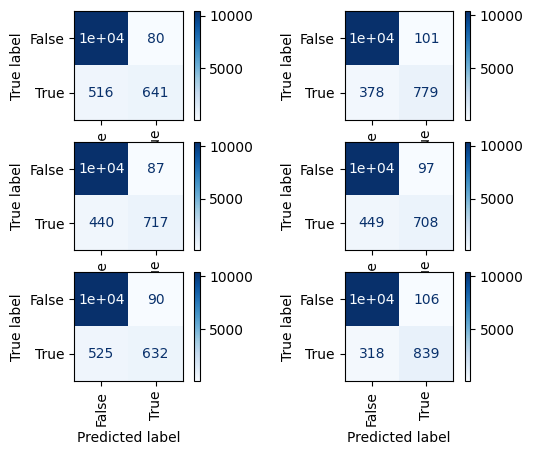

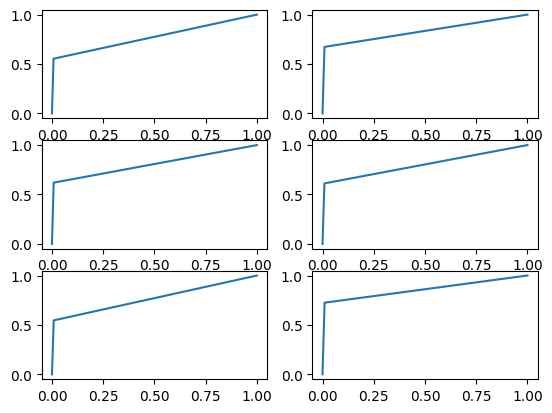

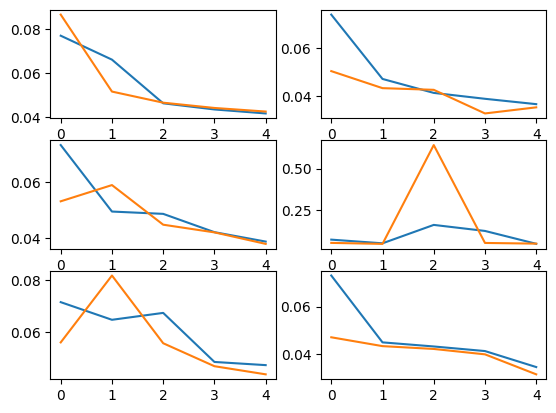

Final proportion: 
Marked example proportion: 0.1081653537685333 - Predicted proportion: 0.05067602387189207


In [25]:
meanPredicted=createTeamOfModels(tf.keras.metrics.Recall())
displaySummarization(meanPredicted)

Epoch 1/5


2023-05-15 00:14:02.512325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:14:02.513228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:14:02.514363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - ETA: 0s - loss: 0.0721 - precision: 0.6887

2023-05-15 00:14:35.712917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:14:35.714314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:14:35.716107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 36s 31ms/step - loss: 0.0721 - precision: 0.6887 - val_loss: 0.0605 - val_precision: 0.7855
Epoch 2/5
1092/1092 [==============================] - 34s 31ms/step - loss: 0.0509 - precision: 0.7469 - val_loss: 0.0697 - val_precision: 0.4723
Epoch 3/5
1092/1092 [==============================] - 34s 31ms/step - loss: 0.0544 - precision: 0.7612 - val_loss: 0.0452 - val_precision: 0.7400
Epoch 4/5
1092/1092 [==============================] - 34s 31ms/step - loss: 0.0464 - precision: 0.8100 - val_loss: 0.0395 - val_precision: 0.8516
Epoch 5/5
   7/4913 [..............................] - ETA: 43s  

2023-05-15 00:16:59.651172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:16:59.652241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:16:59.653605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-15 00:17:42.100169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:17:42.101011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:17:42.102451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - ETA: 0s - loss: 0.0739 - precision: 0.7652

2023-05-15 00:18:15.080429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:18:15.081649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:18:15.083397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 36s 31ms/step - loss: 0.0739 - precision: 0.7652 - val_loss: 0.0486 - val_precision: 0.7583
Epoch 2/5
1092/1092 [==============================] - 37s 33ms/step - loss: 0.0454 - precision: 0.8125 - val_loss: 0.0363 - val_precision: 0.8345
Epoch 3/5
1092/1092 [==============================] - 35s 32ms/step - loss: 0.0373 - precision: 0.8615 - val_loss: 0.0314 - val_precision: 0.8559
Epoch 4/5
1092/1092 [==============================] - 35s 32ms/step - loss: 0.0303 - precision: 0.9037 - val_loss: 0.0259 - val_precision: 0.9426
Epoch 5/5
   8/4913 [..............................] - ETA: 37s  

2023-05-15 00:20:42.171569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:20:42.172632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:20:42.174139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-15 00:21:23.596793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:21:23.597624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:21:23.598875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0707 - precision: 0.8053

2023-05-15 00:22:02.534106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:22:02.535560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:22:02.537092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 42s 37ms/step - loss: 0.0707 - precision: 0.8053 - val_loss: 0.0449 - val_precision: 0.7982
Epoch 2/5
1092/1092 [==============================] - 38s 34ms/step - loss: 0.0481 - precision: 0.7616 - val_loss: 0.0428 - val_precision: 0.8020
Epoch 3/5
1092/1092 [==============================] - 39s 36ms/step - loss: 0.0450 - precision: 0.8130 - val_loss: 0.0390 - val_precision: 0.8279
Epoch 4/5
1092/1092 [==============================] - 40s 37ms/step - loss: 0.0419 - precision: 0.8350 - val_loss: 0.0408 - val_precision: 0.8619
Epoch 5/5
   8/4913 [..............................] - ETA: 37s  

2023-05-15 00:24:45.531746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:24:45.532760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:24:45.534451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-15 00:25:28.165662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:25:28.166487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:25:28.168265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0720 - precision: 0.7885

2023-05-15 00:26:05.175692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:26:05.176916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:26:05.178712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 40s 35ms/step - loss: 0.0720 - precision: 0.7877 - val_loss: 0.0537 - val_precision: 0.6045
Epoch 2/5
1092/1092 [==============================] - 38s 35ms/step - loss: 0.0489 - precision: 0.7676 - val_loss: 0.0462 - val_precision: 0.8045
Epoch 3/5
1092/1092 [==============================] - 38s 35ms/step - loss: 0.0457 - precision: 0.8132 - val_loss: 0.0409 - val_precision: 0.7820
Epoch 4/5
1092/1092 [==============================] - 39s 35ms/step - loss: 0.0426 - precision: 0.8350 - val_loss: 0.0404 - val_precision: 0.8497
Epoch 5/5
   8/4913 [..............................] - ETA: 38s  

2023-05-15 00:28:43.064201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:28:43.065314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:28:43.066616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-15 00:29:24.924727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:29:24.925590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:29:24.926626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0741 - precision: 0.7970

2023-05-15 00:30:08.502850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:30:08.505618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:30:08.506938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 46s 41ms/step - loss: 0.0741 - precision: 0.7967 - val_loss: 0.0467 - val_precision: 0.7582
Epoch 2/5
1092/1092 [==============================] - 42s 38ms/step - loss: 0.0482 - precision: 0.7893 - val_loss: 0.0529 - val_precision: 0.6254
Epoch 3/5
1092/1092 [==============================] - 41s 37ms/step - loss: 0.0476 - precision: 0.7816 - val_loss: 0.0424 - val_precision: 0.7770
Epoch 4/5
1092/1092 [==============================] - 41s 37ms/step - loss: 0.0444 - precision: 0.8155 - val_loss: 0.0397 - val_precision: 0.8042
Epoch 5/5
   7/4913 [..............................] - ETA: 42s  

2023-05-15 00:33:00.057105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:33:00.058131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:33:00.059729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Epoch 1/5


2023-05-15 00:33:41.707786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:33:41.708635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:33:41.709857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.0760 - precision: 0.7214

2023-05-15 00:34:23.786877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:34:23.788128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:34:23.789608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 45s 40ms/step - loss: 0.0760 - precision: 0.7215 - val_loss: 0.0503 - val_precision: 0.7904
Epoch 2/5
1092/1092 [==============================] - 38s 35ms/step - loss: 0.0443 - precision: 0.8027 - val_loss: 0.0396 - val_precision: 0.8720
Epoch 3/5
1092/1092 [==============================] - 36s 33ms/step - loss: 0.0388 - precision: 0.8404 - val_loss: 0.0381 - val_precision: 0.8088
Epoch 4/5
1092/1092 [==============================] - 42s 39ms/step - loss: 0.0349 - precision: 0.8776 - val_loss: 0.0315 - val_precision: 0.8744
Epoch 5/5
   8/4913 [..............................] - ETA: 36s  

2023-05-15 00:37:10.258408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 00:37:10.259492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 00:37:10.261303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

364/364 [==============================] - 3s 8ms/step
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.05220708811619424
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.049937219491344303
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.11341294124312992
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.06445431523637989
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.04306832809161724
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.09217921729645609


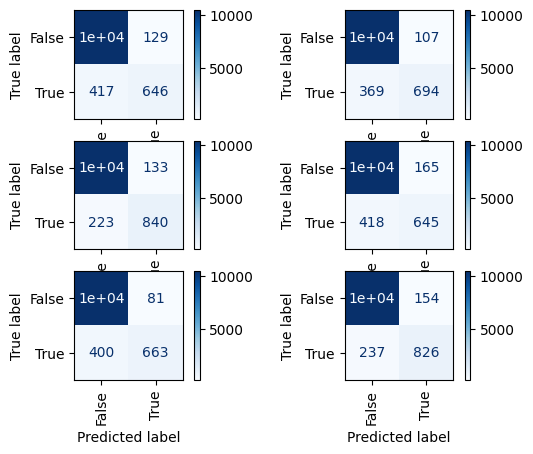

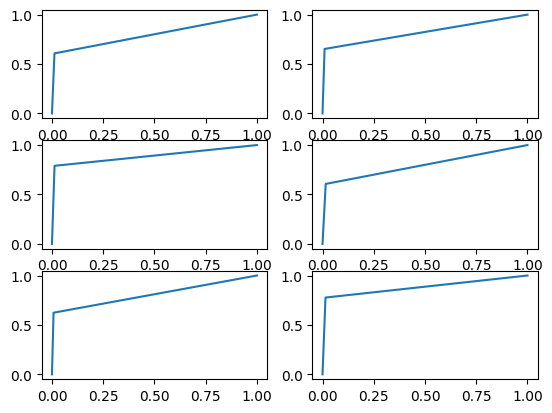

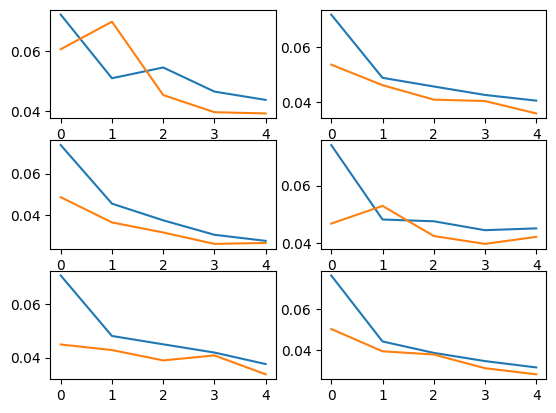

Final proportion: 
Marked example proportion: 0.1081653537685333 - Predicted proportion: 0.06920985157918695


In [15]:
meanPredicted=createTeamOfModels(tf.keras.metrics.Precision())
displaySummarization(meanPredicted)